## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

a. Read in the dataset and take a look at the top few rows here:

In [2]:
#reading the dataset
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
#Number of rows
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
#Number of unique users
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
#Proportion of users converted
len(df[df['converted'] ==1]) / df['user_id'].nunique()

0.12126269856564711

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
#Number of rows that follows:
#When group is treatment but landing_page is not new_page,
#When group is not treatment but landing_page is new_page
df2 = df.query('(group == "treatment" & landing_page != "new_page") or (group != "treatment" & landing_page == "new_page")')
df2.shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
#Checking data for Null Values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
#Dropping rows that may have wrong information
df2 = df.drop(df.query('(group == "treatment" & landing_page != "new_page") or (group != "treatment" & landing_page == "new_page")').index)

In [9]:
#Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

a. How many unique **user_id**s are in **df2**?

In [10]:
#Unique users in the new dataframe
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
#Duplicated user
df2[df2.duplicated(['user_id'])]['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
#Row of the duplicated user_id
df2[df2['user_id'].duplicated() == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
#Dropping duplicated user_id
df2 = df2.drop(index=2893)

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
#Probability of converting regardless of the page
len(df2[df2['converted'] ==1]) / df2['user_id'].nunique()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
#Probability of converting when group is control
len(df2.query('group == "control" & converted == 1')) / len(df2.query('group == "control"'))

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
#Probability of converting when group is treatment
len(df2.query('group == "treatment" & converted == 1')) / len(df2.query('group == "treatment"'))

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
#Probability of landing on the new page
len(df2.query('landing_page == "new_page"')) / df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**There is no sufficient evidence prove that new treatment page leads more conversions as questions 'B' & 'C' clarify that Old control page has slightly higher conversion rate.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**
#Null Hypotheses:
Old page is better than or equal new page
#P_𝑜𝑙𝑑  >= P_𝑛𝑒𝑤
#Alternative Hypotheses:
Old page is worse than new page
#P_𝑜𝑙𝑑  < P_𝑛𝑒𝑤

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [18]:
#Conversuin of P_new rate under null
p_new = len(df2.query('converted == 1 '))/df['user_id'].nunique()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [19]:
#Conversuin of P_old rate under null
p_old = len(df2.query('converted == 1 '))/df['user_id'].nunique()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [20]:
#Number of individulas in the treatment group
n_new = df2.query('group == "treatment" &landing_page == "new_page"')['user_id'].nunique()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [21]:
#Number of individuals in the control group
n_old = df2.query('group == "control" & landing_page == "old_page"')['user_id'].nunique()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
#Simulating the conversion rate of the new page uner null
new_page_converted = np.random.choice([0,1],size= n_new,p=(p_new,1-p_new))
new_page_converted.mean()

0.88109558874131166

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
#Simulating the conversion rate of the old page uner null
old_page_converted = np.random.choice([0,1],size= n_old,p=(p_old,1-p_old))
old_page_converted.mean()

0.87988215372330902

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
#Difference between conversion rates of new and old pages
diff = new_page_converted.mean() - old_page_converted.mean()
diff

0.0012134350180026399

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [25]:
#Creating 10,000 values of the difference between simulation of new & old pages conversion rates
p_diffs = []
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new 
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old 
p_diffs = new_converted_simulation - old_converted_simulation

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

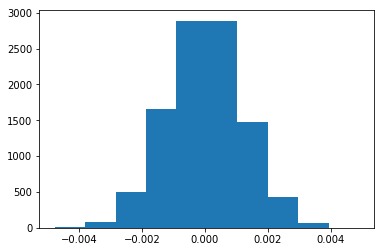

In [26]:
#Displaying histogram of the results
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
#The actual difference in the dataset
new_conversion = df2.query('landing_page == "new_page" & converted == 1')['user_id'].nunique()/n_new
old_conversion = df2.query('landing_page == "old_page" & converted == 1')['user_id'].nunique()/n_old
differ = new_conversion - old_conversion

#proportion of the **p_diffs** that are greater than the actual difference  
x = [value for value in p_diffs if value > differ]
prop = len(x)/len(p_diffs)
prop

0.9058

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**While P-value > α, We fail to reject null hypothesis.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [28]:
import statsmodels.api as sm

old_conversion = df2.query('landing_page == "old_page"')['converted'].sum()
new_conversion = df2.query('landing_page == "new_page"')['converted'].sum()
n_old = df2.query('group == "control" & landing_page == "old_page"')['user_id'].nunique()
n_new = df2.query('group == "treatment" &landing_page == "new_page"')['user_id'].nunique()

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [29]:
counts = np.array([old_conversion, new_conversion])
nobs = np.array([n_old, n_new])
test= sm.stats.proportions_ztest(counts,nobs,alternative= 'smaller')
print("z_test, p_value:", test)

z_test, p_value: (1.3109241984234394, 0.90505831275902449)


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**While z-score is 0.1.311 to close to 0 indicates the data point's score is are too close to the mean score., and p-value of 0.5 indicates its not statistically significance. **

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [30]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [31]:
mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [32]:
results = mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-09-01 07:28 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br> 

**The p-value associated with ab_page is 0.1899,The null hypotheses there is no difference between control or treatment groups, and the alternative hypotheses there is difference between them. **

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Considering other facotrs to regression model may help us understand the relationships among the dataset,  as well as understanding the correlation between dependant and independat variables, While there's a close relationship between three or more variables it's usually hard to detect,The coefficients might be poorly estimated, or inflated.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.

In [33]:
countries = pd.read_csv('countries.csv')
df2 = df2.merge(countries)
df2[['CA','UK','US']] = pd.get_dummies(df2['country'])
df2['ab_UK'] = df2['ab_page'] * df2['UK']
df2['ab_CA'] = df2['ab_page'] * df2['CA']

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [34]:
df2['intercept'] = 1
mod = sm.Logit(df2['converted'], df2[['intercept','ab_page','ab_UK', 'ab_CA','UK','CA']])
results = mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-09-01 07:28 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
ab_UK         0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
ab_CA        -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
==================================================================

"""

In [35]:
#exponentiate of coefs
ab_page, ab_UK, ab_CA, UK, CA = np.exp(-0.0206),np.exp(0.0314),np.exp(-0.0469),np.exp(-0.0057),np.exp(-0.0175)
ab_page, ab_UK, ab_CA, UK, CA

(0.97961073050325054,
 1.0318981806179213,
 0.95418281110072622,
 0.99431621417843319,
 0.9826522356650732)

##### Conclusions
#All variables p-values are more than 0.05 but intercept's which is statistically significant, while all other variables are not.
#So countries are not statistically signficant on the conversion rate.
#conversion is 1.0318 times as likely for UK and new page users than US holding all else constant
#conversion is 0.9541 times as likely for CA and new page users than US holding all else constant
#conversion is 0.9943 % as likely for users in UK than US holding all else contstant 
#conversion is 0.9826 % as likely for users in CA than US holding all else contstant
#we fail to reject null, so they should keep the old page

In [36]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0